
# Projet sous Spark : accidents de la circulation en France entre 2012 et 2019


Auteur : Ivanhoé Botcazou


Date : 26 octobre 2023


## Analyse des données avec les outils de SparkSession


Les données misent à notre disposition sont des tableaux au format 'csv'. Nous retrouvons par année différentes modalités sur les accidents de la circulation routière : caractéristiques, usagers, lieux et véhicules. Dans une première phase d'exploration des données, nous chercherons à répondre aux questions suivantes :


* Quelle est l'évolution du nombre d'accidents de la circulation en France par année ?
* Y a-t-il une région française plus touchée par les accidents de la circulation ?
* Quelles sont les 10 communes ou il y a le plus d'accidents de la route par ans ?
* Quelle période de l'année recense le plus d'accidents ?
* Le niveau d'éclairage au moment de l'accident est-il un facteur aggravant ?
* Quelle est l'évolution du nombre de morts et de blessés sur la route en France par année ?
* Quelles sont les 10 catégories de véhicules les plus meurtrières sur ces années ?
* Quelle classe d'âge est la plus touchée dans des accidents meurtriers sur la route ?
* Quelles sont les 100 personnes les plus impliquées dans des accidents de la route sur ces années d'études ?



In [236]:
#Modules

import os 
from pyspark.sql import SparkSession
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sn 

from pyproj import Transformer #Pour les coordonnées gps sous un format UTM
from pyspark.sql.types import StringType #Type pour une colonne 

from functools import reduce #empiler tous les DataFrames
from pyspark.sql import DataFrame


from pyspark.sql.functions import * 


### Chargement des données et exploration

In [181]:
#Chargement des données

spark = SparkSession.builder.master("local").appName('Botcazou').getOrCreate()


path = '/home/ibotcazou/Bureau/Master_data_science/DATAS_M2/Informatique_charbonel_Marie/DATA_Marie/projet_spark'

Annees = range(2012,2019)

car,usa,lieux,vehi = {},{},{},{}

for a in Annees:
    car[f'car_{a}'] = spark.read.load(path + f"/caracteristiques_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")
    usa[f'usa_{a}'] = spark.read.load(path + f"/usagers_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")
    lieux[f'lieux_{a}'] = spark.read.load(path + f"/lieux_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")
    vehi[f'vehi_{a}'] = spark.read.load(path + f"/vehicules_{a}.csv",format="csv", sep=",", inferSchema="true", header="true")

In [84]:
#Visualisation du dataset Caractéristiques
car['car_2012'].show(14)

+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
|     Num_Acc| an|mois|jour|hrmn|lum|agg|int|atm|col|com|                 adr|gps|    lat|  long|dep|
+------------+---+----+----+----+---+---+---+---+---+---+--------------------+---+-------+------+---+
|201200000001| 12|   3|  16|1930|  5|  2|  1|  1|  6| 11|33 Rue Roger Sale...|  M|5052928|293643|590|
|201200000002| 12|   9|   1|2145|  5|  2|  1|  1|  3| 11|        route de DON|  M|5053380|292738|590|
|201200000003| 12|  11|  20|1815|  5|  2|  1|  1|  5|670|  rue Anatole France|  M|5054757|292033|590|
|201200000004| 12|   1|   7|1915|  5|  2|  1|  1|  3| 51|      Rue d'ESTAIRES|  M|5053315|280229|590|
|201200000005| 12|   1|  17|2000|  5|  2|  1|  1|  1|524|Rue du G�n�ral Le...|  M|5055855|290642|590|
|201200000006| 12|   1|  22|1800|  5|  2|  1|  1|  6| 51|  34 rue de la Marne|  M|5053665|280409|590|
|201200000007| 12|   4|  14|1645|  1|  2|  1|  1|  6| 51|      13 RUE DE LENS|  M|

In [85]:
# Connaître la nature des colonnes

car['car_2012'].printSchema()


root
 |-- Num_Acc: long (nullable = true)
 |-- an: integer (nullable = true)
 |-- mois: integer (nullable = true)
 |-- jour: integer (nullable = true)
 |-- hrmn: integer (nullable = true)
 |-- lum: integer (nullable = true)
 |-- agg: integer (nullable = true)
 |-- int: integer (nullable = true)
 |-- atm: integer (nullable = true)
 |-- col: integer (nullable = true)
 |-- com: integer (nullable = true)
 |-- adr: string (nullable = true)
 |-- gps: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: integer (nullable = true)
 |-- dep: integer (nullable = true)



### Évolution du nombre d'accidents de la circulation en France par année.

Pour cette question nous allons utiliser le nombre de lignes des tableaux 'Caractéristiques' par années. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


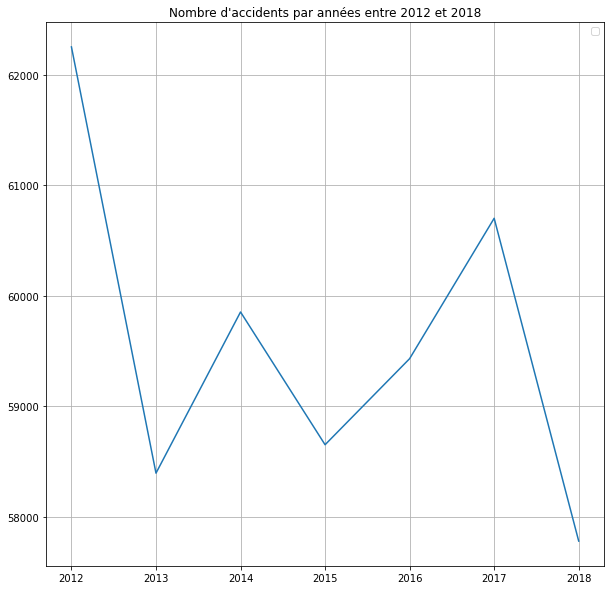

In [86]:
# Nombre d'accidents par ans

nb_acc = []
for i in Annees:
    nb_acc.append(car[f'car_{i}'].count())

plt.figure(figsize=(10,10))
plt.plot(Annees,nb_acc)
plt.grid()
plt.title("Nombre d'accidents par années entre 2012 et 2018" )
plt.legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

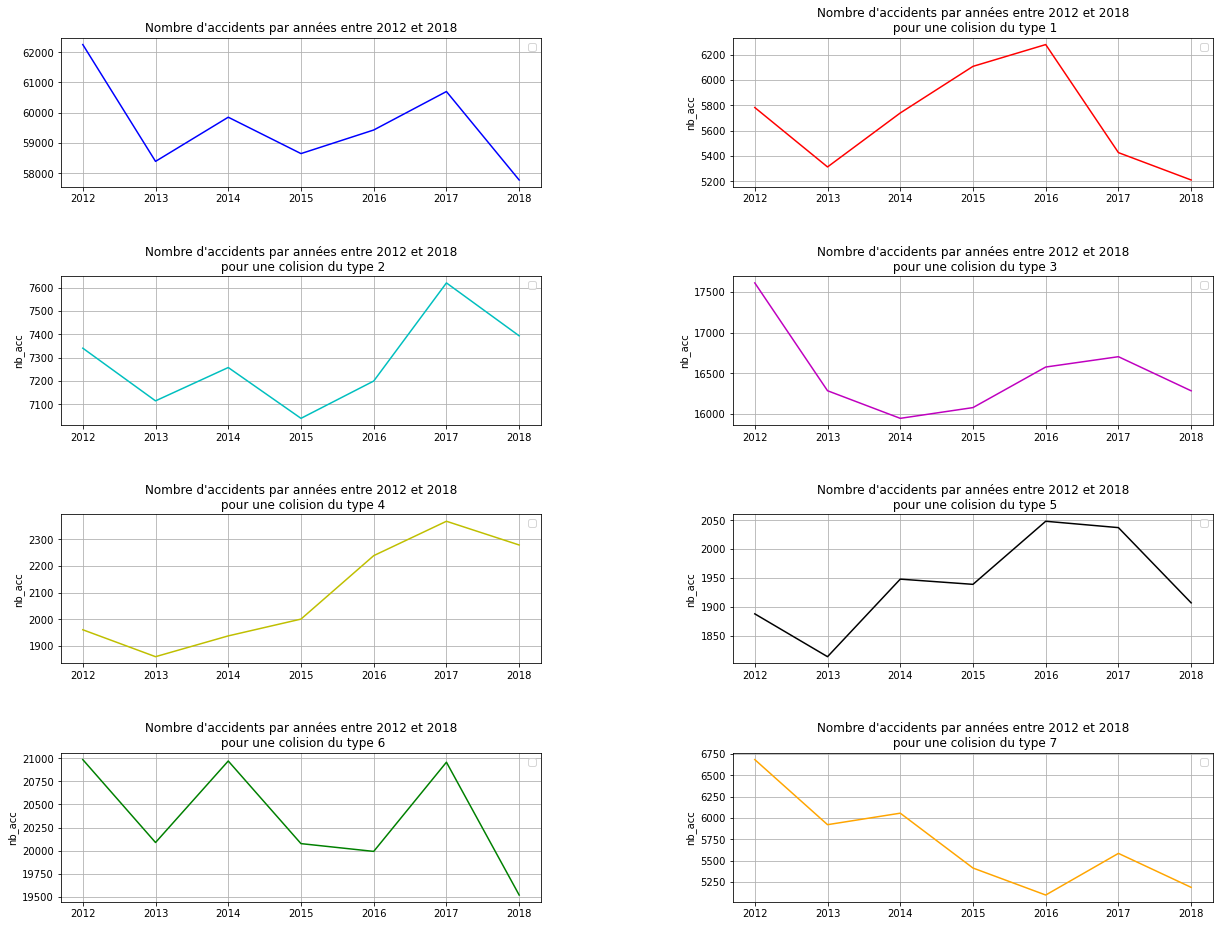

In [87]:
#Nombre d'accidents par type de colision 

type_col = range(1,8)
nb_ac_col = {f'col_{i}':[] for i in type_col}

for a in Annees:
    for col in type_col:
        nb_ac_col[f'col_{col}'].append(car[f'car_{a}'].filter(car[f'car_{a}']['col']==col).count())


#Partie plot 

plt.figure(figsize=(20,15))
# Définir une palette de couleurs
colors = ['g', 'r', 'c', 'm', 'y', 'k','g','orange']

plt.subplot(4,2,1)
plt.plot(Annees,nb_acc,c='b')
plt.grid()
plt.title("Nombre d'accidents par années entre 2012 et 2018" )
plt.legend()
for j in range(1,8):
    plt.subplot(4,2,j+1)
    plt.plot(Annees,nb_ac_col[f'col_{j}'],c=colors[j])
    plt.ylabel("nb_acc")
    plt.grid()
    plt.title(f"Nombre d'accidents par années entre 2012 et 2018\n pour une colision du type {j}" )
    plt.legend()

# Ajustement de l'espacement
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

plt.show()




## Zone géographique française avec le plus de recensement d'accidents de la circulation en fonction des années

Nous allons partager la France en 6 parties distinctes entre le nord, le sud, l'ouest, l'est et le centre (NO,NC,NE,SO,SC,SE). Approximativement, les deux villes repères pour la longitude sont Le Mans et Reims, pour la latitude nous avons choisi Bourge.  

In [237]:
CAT_GPS = ["NO","NC","NE","SO","SC","SE"] #Région géographique

def Find_CAT(gps):
    CAT = ""
    if gps[1]<=47:
        CAT = "S"
    else:
        CAT = "N"
    if gps[0]<= 0:
        CAT += "O"
    elif gps[0]>= 4:
        CAT += "E"
    else:
        CAT += "C"
    return CAT 

# Créer un transformateur car les données GPS ne sont par sous un format habituel
transformer = Transformer.from_crs("epsg:32632", "epsg:4326", always_xy=True) #Paris est la référence

# Fonction pour convertir les coordonnées UTM en Lat/Long
def convert(lat, lon):
    try:
        lat, lon = float(lat), float(lon)
        return Find_CAT(transformer.transform(lon, lat)) 
    except (TypeError, ValueError):
        return None 



In [238]:
df = {}
# Créer UDF pour Spark
convert_udf = udf(convert, StringType())

for a in Annees:
    df[f"{a}"] = car[f'car_{a}'].filter(car[f'car_{a}']['gps']=='M')
    # Appliquer l'UDF pour créer une nouvelle colonne 'lat_long'
    df[f"{a}"] = df[f"{a}"].withColumn("CAT", convert_udf(df[f"{a}"]["lat"], df[f"{a}"]["long"]))
    df[f"{a}"] = df[f"{a}"].filter(df[f"{a}"]['CAT']!= "NULL")



In [226]:
for a in Annees:
    print(f"Pour l'année {a} les zones géographiques sont les suivantes avec un nombre d'accidents associé:")
    #df[f'{a}'].select('CAT').distinct().show()
    df[f'{a}'].groupBy('CAT').count().show()


Pour l'année 2012 les zones géographiques sont les suivantes avec un nombre d'accidents associé:
+---+-----+
|CAT|count|
+---+-----+
| SC| 4168|
| SO| 1392|
| SE|21706|
+---+-----+

Pour l'année 2013 les zones géographiques sont les suivantes avec un nombre d'accidents associé:
+---+-----+
|CAT|count|
+---+-----+
| SC| 4809|
| SO| 1336|
| SE|20793|
+---+-----+

Pour l'année 2014 les zones géographiques sont les suivantes avec un nombre d'accidents associé:


+---+-----+
|CAT|count|
+---+-----+
| SC| 5434|
| SO| 1314|
| SE|22535|
+---+-----+

Pour l'année 2015 les zones géographiques sont les suivantes avec un nombre d'accidents associé:
+---+-----+
|CAT|count|
+---+-----+
| SC| 8410|
| SO| 1329|
| SE|25460|
+---+-----+

Pour l'année 2016 les zones géographiques sont les suivantes avec un nombre d'accidents associé:


+---+-----+
|CAT|count|
+---+-----+
| SC| 9142|
| SO| 1446|
| SE|35088|
+---+-----+

Pour l'année 2017 les zones géographiques sont les suivantes avec un nombre d'accidents associé:


+---+-----+
|CAT|count|
+---+-----+
| SC| 9676|
| SO| 1742|
| SE|40437|
+---+-----+

Pour l'année 2018 les zones géographiques sont les suivantes avec un nombre d'accidents associé:
+---+-----+
|CAT|count|
+---+-----+
| SC| 9216|
| SO| 1650|
| SE|43108|
+---+-----+



Nous remarquons que les recenssements d'accidents sont uniquement dans le sud de la France et que particulièrement il y en a beaucoup plus dans le sud est de la france que dans les autres zones géographiques. 

## Les 10 villes les plus touchées par les accidents de la routes entre 2012 et 2018



In [247]:
df_12_18 = car['car_2012']  

# Parcourir la liste des DataFrames et les unir un par un
for a in Annees[1:]:  # Commencer à partir du deuxième élément, car le premier est déjà dans df_12_18
    df_12_18 = df_12_18.unionByName(car[f'car_{a}'])

# Group by 'com' et compter
count = df_final.groupBy('com').count()

# Afficher les 10 premières communes avec le plus grand nombre de lignes
count.orderBy('count', ascending=False).show(10)

+---+-----+
|com|count|
+---+-----+
| 55|17830|
|116| 5032|
|113| 4807|
| 88| 4719|
|117| 4701|
| 63| 4688|
|  7| 4674|
|112| 4384|
|118| 3877|
| 69| 3842|
+---+-----+
only showing top 10 rows



Les communes avec les plus d'accidents sont référencées par les index : 55, 116, 113, 88, 117, 63, 7, 112, 118, 69

## Accidents par périodes de l'année entre 2012 et 2018

Pour simplifier notre étude, nous associerons l'hiver aux mois de janvier, février et mars. Nous associerons le printemps aux mois d'avril, mai et juin. Nous associerons l'été aux mois de juillet, août et septembre. Enfin, nous associerons l'automne aux mois d'octobre, novembre et décembre.


In [260]:
Hiver = df_12_18.filter(col('mois').isin([1, 2, 3])).count()
Printemps = df_12_18.filter(col('mois').isin([4, 5, 6])).count()
Ete = df_12_18.filter(col('mois').isin([7, 8, 9])).count()
Automne = df_12_18.filter(col('mois').isin([10, 11, 12])).count()

print("Entre 2012 et 2018 le nombre d'accidents suivant la période de l'année :")
print("Hiver = ", Hiver)
print("Printemps = ",Printemps )
print("Ete= ",Ete )
print("Automne  = ",Automne )

Entre 2012 et 2018 le nombre d'accidents suivant la période de l'année :
Hiver =  92382
Printemps =  108118
Ete=  106160
Automne  =  110411


In [267]:

M = (Hiver +Printemps+Ete+Automne)/4
print(Automne/M)
print(Hiver/M)

1.0589180259476205
0.8860074184011835


Le nombre d'accidents en Automne est 5% plus plus grand que le nombre moyen d'accidents par période. À l'inverse le nombre d'accidents en Hiver est 11% plus plus petit que le nombre moyen d'accidents par période.

## Nombre d'accidents en fonction de l'éclairage et du niveau d'aglomération:

Dans cette partie, nous allons étudier la distribution des accidents de la route sous le spectre du niveau d'éclairage au moment de l'accident. Nous étudierons ensuite le lien avec le niveau d'aglomération. 



1 Plein jour,

2 Crépuscule ou aube,

3 Nuit sans éclairage public,

4 Nuit avec éclairage public non allumé,

5 Nuit avec éclairage public allumé.

In [334]:
df_12_18.groupBy('lum').count().orderBy("count",ascending=False).show()
df_12_18.groupBy('agg').count().show()
df_12_18.groupBy(['lum','agg']).count().orderBy("count",ascending=False).show()

+---+------+
|lum| count|
+---+------+
|  1|284241|
|  5| 68148|
|  3| 34910|
|  2| 25989|
|  4|  3783|
+---+------+



+---+------+
|agg| count|
+---+------+
|  1|139882|
|  2|277189|
+---+------+



+---+---+------+
|lum|agg| count|
+---+---+------+
|  1|  2|191200|
|  1|  1| 93041|
|  5|  2| 62099|
|  3|  1| 29296|
|  2|  2| 16048|
|  2|  1|  9941|
|  5|  1|  6049|
|  3|  2|  5614|
|  4|  2|  2228|
|  4|  1|  1555|
+---+---+------+



In [339]:
# récupérer le résultat avec la commande collect()
result = df_12_18.groupBy('lum').count().orderBy("lum",ascending=True).collect()

# Conversion array
matrix = np.array([(row['lum'], row['count']) for row in result])

P = matrix[:,1]/matrix[:,1].sum()
L = matrix[:,0]

M = np.stack((L,P))
M


array([[1.        , 2.        , 3.        , 4.        , 5.        ],
       [0.68151706, 0.06231313, 0.08370277, 0.0090704 , 0.16339664]])

Il n'y a pas équiprobabilité sur le niveau de luminosité sachant qu'il y a eu un accident.  

In [346]:
# récupérer le résultat avec la commande collect()
result = df_12_18.groupBy(['lum','agg']).count().orderBy("count",ascending=False).collect()

# Conversion array
matrix = np.array([(row['lum'], row['agg'],row['count']) for row in result])


P = matrix[:,2]/matrix[:,2].sum()
P= P.reshape((P.shape[0],1))
L = matrix[:,0:2]

M = np.round(np.hstack((L,P)),2)
M

array([[1.  , 2.  , 0.46],
       [1.  , 1.  , 0.22],
       [5.  , 2.  , 0.15],
       [3.  , 1.  , 0.07],
       [2.  , 2.  , 0.04],
       [2.  , 1.  , 0.02],
       [5.  , 1.  , 0.01],
       [3.  , 2.  , 0.01],
       [4.  , 2.  , 0.01],
       [4.  , 1.  , 0.  ]])

On peut supposer que le niveau d'agglomération 2 est en ville etque le niveau 1 est en campagne. On remarque que les accidents arrivent particulièrement en plein jour et presque une fois sur deux en ville et en plein jour. On remarque que 7% des accidents arrivent en pleine nuit dans des des lieux sans éclairage public. Intéressons nous sur le type de d'obstacle rencontré ou non pour cette catégorie ([3.  , 1.])



In [353]:
df_12_18.groupBy(['Num_Acc']).count().orderBy('count',ascending=False).show()
#Cette commande nous permet de vérifier que chaque accident à un unique identifiant au niveau des caractéristiques. 

+------------+-----+
|     Num_Acc|count|
+------------+-----+
|201200000088|    1|
|201200000209|    1|
|201200000276|    1|
|201200000483|    1|
|201200000743|    1|
|201200000960|    1|
|201200001124|    1|
|201200001266|    1|
|201200001349|    1|
|201200001512|    1|
|201200001613|    1|
|201200001614|    1|
|201200001793|    1|
|201200001987|    1|
|201200002443|    1|
|201200002516|    1|
|201200002640|    1|
|201200002670|    1|
|201200002753|    1|
|201200002975|    1|
+------------+-----+
only showing top 20 rows



In [ ]:
car_3_1_12_18 = df_12_18.filter(col('lum')=="3" ).filter(col('agg')==1)

vehi_12_18 = vehi["vehi_2012"]

for a in Annees[1:]:
    vehi_12_18 = vehi_12_18.unionByName(vehi[f"vehi_{a}"])

vehi_12_18.groupBy(['Num_Acc']).count().orderBy('count',ascending=False).show()



+------------+-----+
|     Num_Acc|count|
+------------+-----+
|201600002473|   35|
|201300003075|   28|
|201200012658|   26|
|201200022945|   25|
|201200024578|   18|
|201600020435|   18|
|201500012022|   16|
|201200012460|   15|
|201200050307|   15|
|201500048252|   15|
|201700051521|   15|
|201200023347|   14|
|201500028308|   13|
|201800005731|   13|
|201200012813|   12|
|201500049330|   12|
|201200012066|   12|
|201600013009|   12|
|201800007042|   12|
|201200060940|   12|
+------------+-----+
only showing top 20 rows



In [ ]:
resultat = vehi_12_18.select(['obs','obsm']).join(car_3_1_12_18, car_3_1_12_18['Num_Acc'] == car_3_1_12_18['Num_Acc'])


23/10/26 20:52:58 WARN Column: Constructing trivially true equals predicate, 'Num_Acc#26393L = Num_Acc#26393L'. Perhaps you need to use aliases.


In [ ]:
resultat.groupBy('obsm').count().show()

: 

## Nombre de personnes tués sur la route ou bien blessés. 

Dans cette partie, nous allons travailler avec les DataFrame "user"